# Cactus Identification using ResNet

## 1. Introduction

## 2. Environment Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from zipfile import ZipFile
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

2025-04-22 03:16:43.884793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745291804.334082      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745291804.467939      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def setup_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        device = 'TPU'
    except:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            strategy = tf.distribute.MirroredStrategy() if len(gpus) > 1 else tf.distribute.get_strategy()
            device = f'{len(gpus)} GPU(s)'
        else:
            strategy = tf.distribute.get_strategy()
            device = 'CPU'
    print(f'Using {device} with {strategy.num_replicas_in_sync} replicas')
    return strategy

strategy = setup_strategy()

Using 2 GPU(s) with 2 replicas


I0000 00:00:1745291826.966613      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745291826.967309      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## 3. Data Loading and EDA

In [3]:
with ZipFile('/kaggle/input/aerial-cactus-identification/train.zip') as zipper:
    zipper.extractall()
    
with ZipFile('/kaggle/input/aerial-cactus-identification/test.zip') as zipper:
    zipper.extractall()

In [4]:
labels = pd.read_csv('/kaggle/input/aerial-cactus-identification/train.csv')
submission = pd.read_csv('/kaggle/input/aerial-cactus-identification/sample_submission.csv')

In [5]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [6]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [7]:
num_train = len(os.listdir('/kaggle/working/train'))
num_test = len(os.listdir('/kaggle/working/test'))

print(f'number of train images: {num_train}')
print(f'number of test images: {num_test}')

cactus_count = labels['has_cactus'].sum()
no_cactus_count = len(labels) - cactus_count

print(f"number with cactus: {cactus_count} ({cactus_count/len(labels)})")
print(f"number without cactus: {no_cactus_count} ({no_cactus_count/len(labels)})")

sample_img = cv2.imread('/kaggle/working/train/' + labels['id'].iloc[9])
print(f"image shape: {sample_img.shape}")

number of train images: 17500
number of test images: 4000
number with cactus: 13136 (0.7506285714285714)
number without cactus: 4364 (0.24937142857142858)
image shape: (32, 32, 3)


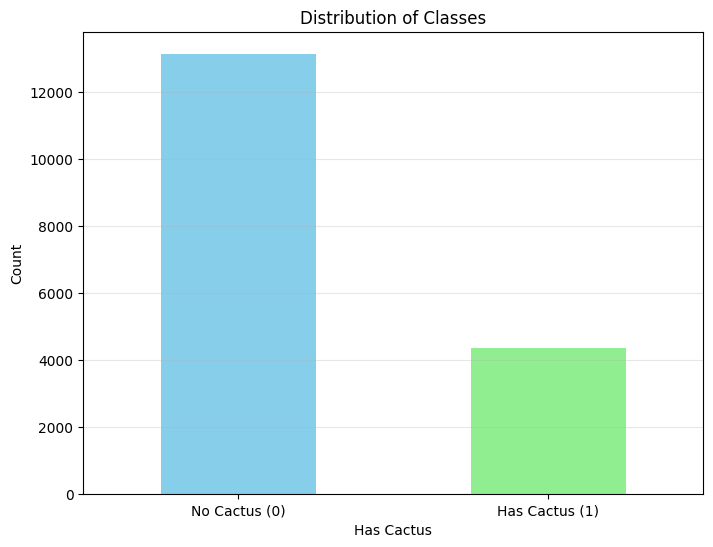

In [8]:
plt.figure(figsize=(8, 6))
labels['has_cactus'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Distribution of Classes')
plt.xlabel('Has Cactus')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Cactus (0)', 'Has Cactus (1)'], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

We can address the class imbalance by calcualting the class weights and use these for training.

In [9]:
def display_aerial_images(labels=None, n_images=12, has_cactus=True):
    n_rows = int(np.floor(np.sqrt(n_images)))
    n_cols = int(np.ceil(n_images/n_rows))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
    axes = axes.flatten()  

    if has_cactus:
        images = labels[labels['has_cactus'] == 1]['id'][-n_images:]
    else:
        images = labels[labels['has_cactus'] == 0]['id'][-n_images:]

    for idx, img_name in enumerate(images):
        img_path = 'train/' + img_name                 
        image = cv2.imread(img_path)                   
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        
        axes[idx].imshow(image)
        axes[idx].axis('off') 
        
        for i in range(len(images), len(axes)):
            axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

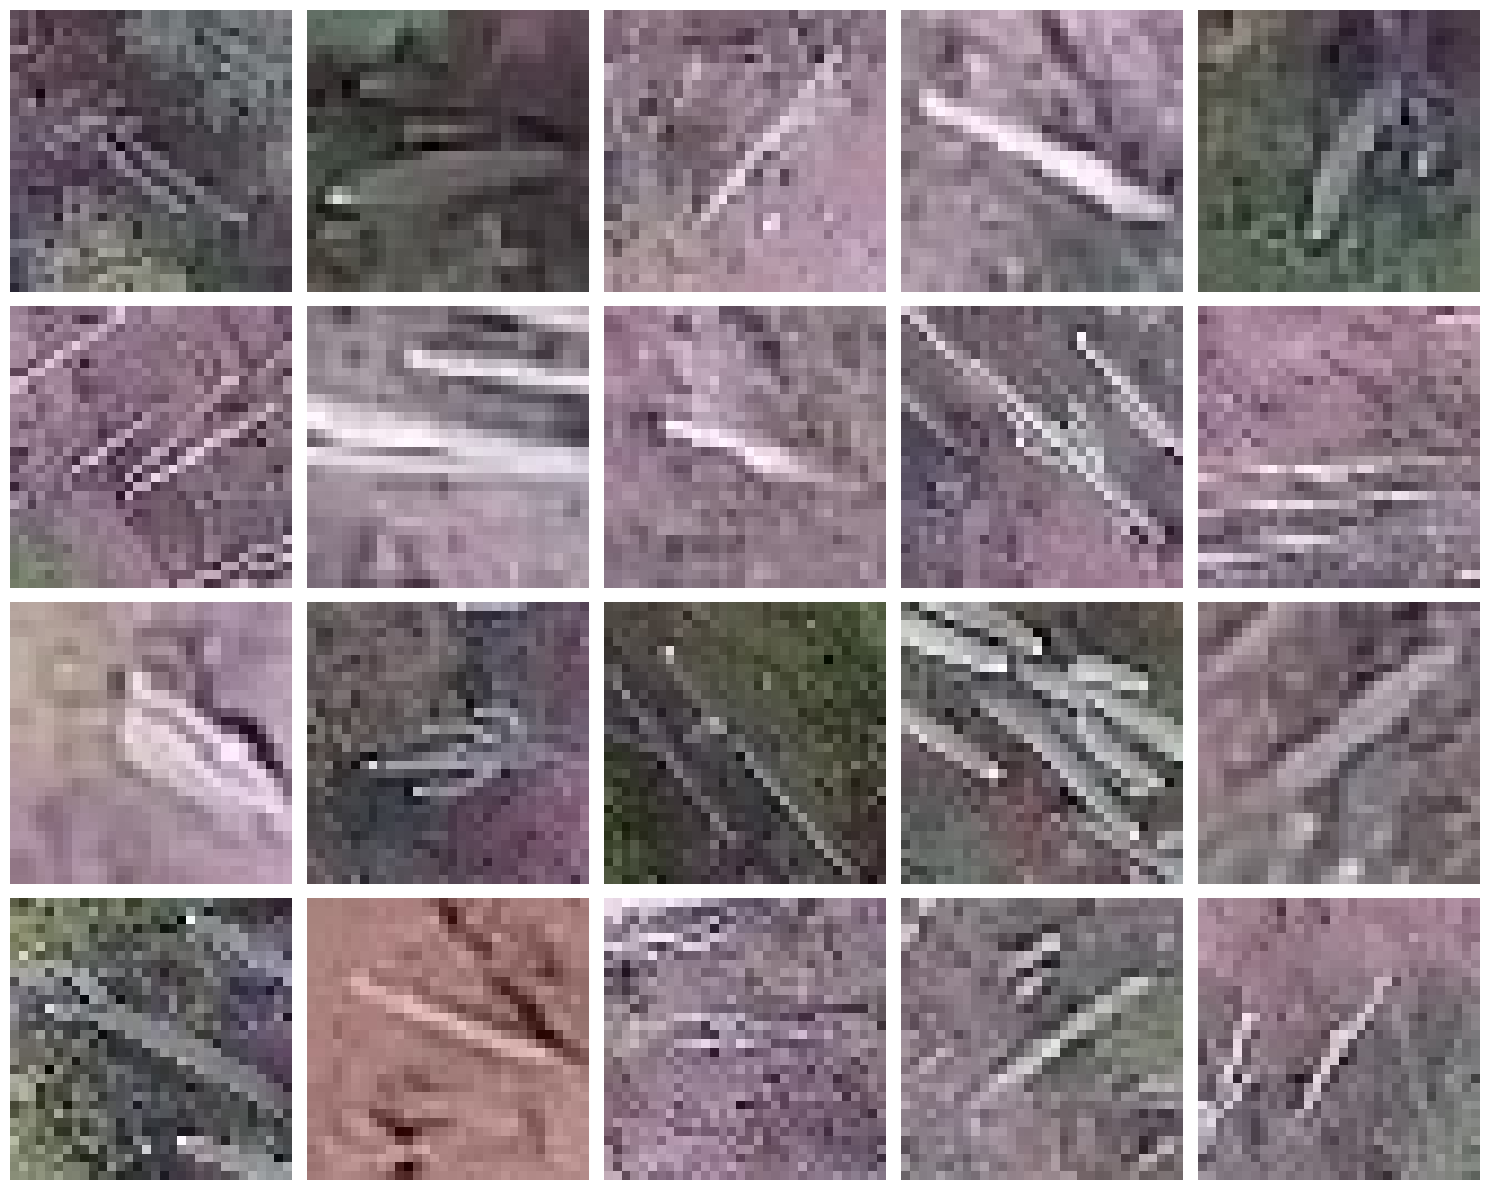

In [10]:
display_aerial_images(labels=labels, n_images=20, has_cactus=True)

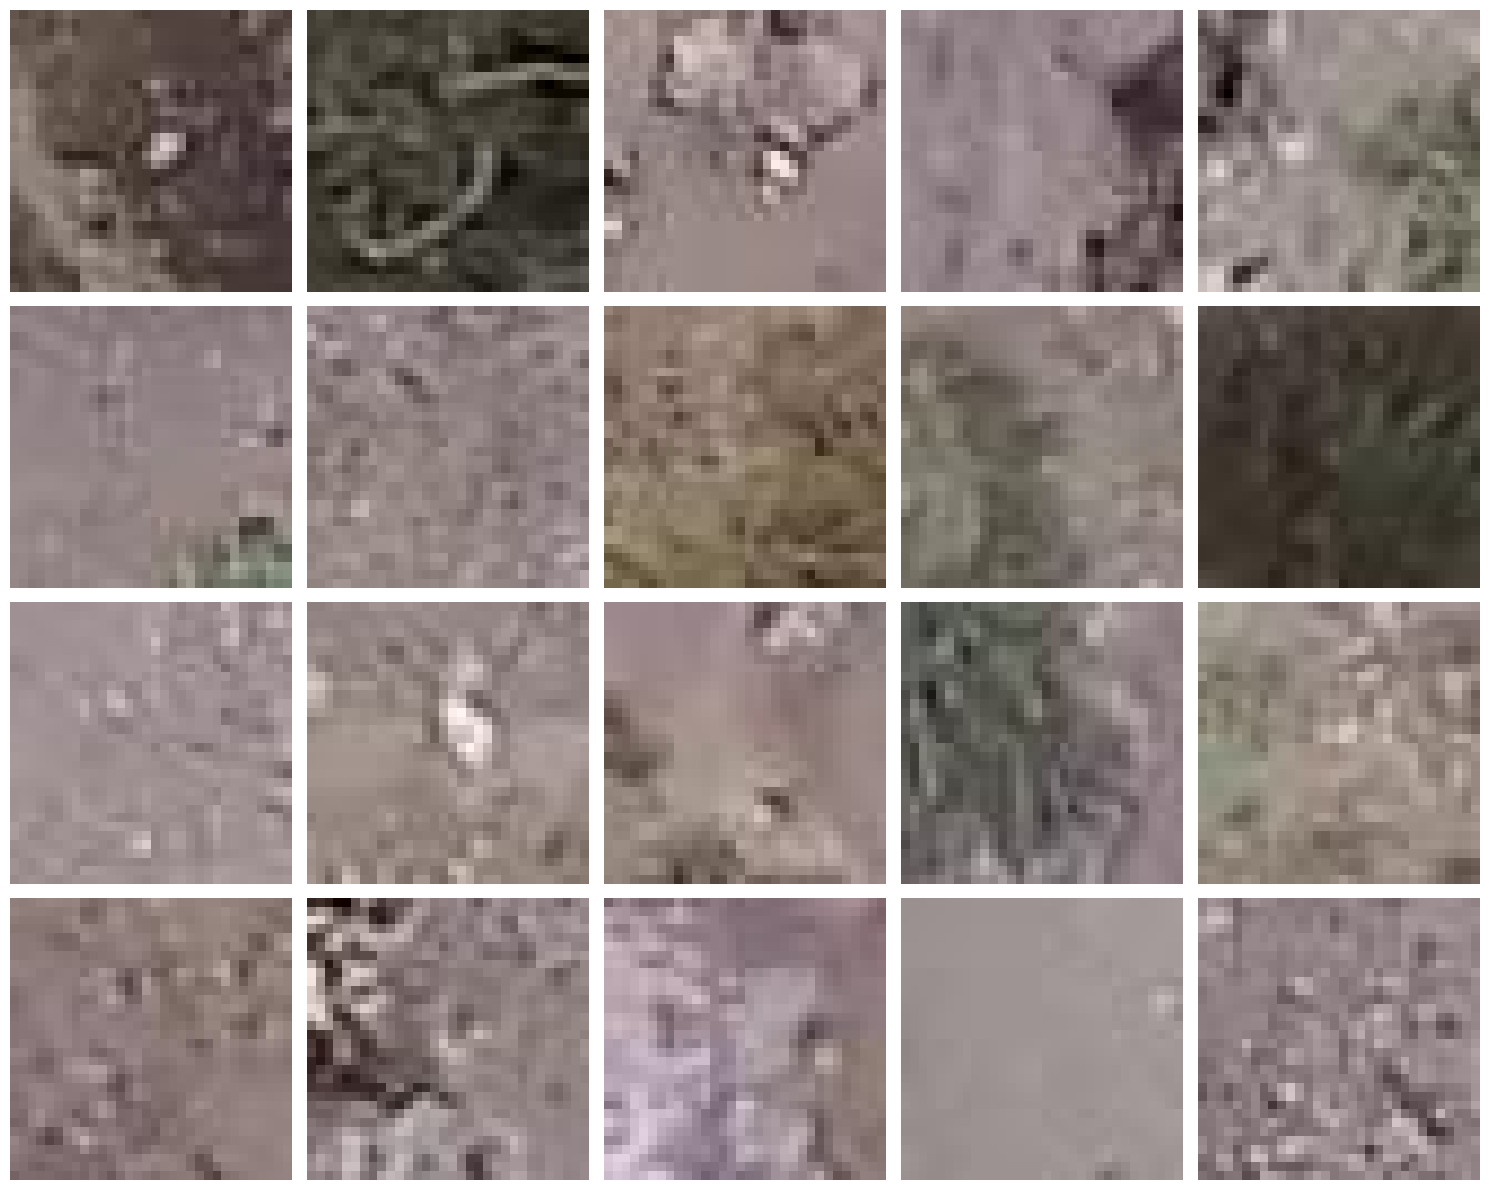

In [11]:
display_aerial_images(labels=labels, n_images=20, has_cactus=False)

## 4. Data Preprocessing

In [12]:
# Create train and validation splits
train_df, val_df = train_test_split(labels, 
                                    test_size=0.2, 
                                    stratify=labels['has_cactus'], 
                                    random_state=42)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")

Training set: 14000 images
Validation set: 3500 images


In [13]:
IMG_SIZE = 224
batch_size = 128

# used for training
datagen_augmentation = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# used for val and test
datagen_val_rescale = ImageDataGenerator(preprocessing_function=preprocess_input)
datagen_test_rescale = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
# Convert has_cactus to string for compatibility with flow_from_dataframe
train_df['has_cactus'] = train_df['has_cactus'].astype(str)
val_df['has_cactus'] = val_df['has_cactus'].astype(str)

In [15]:
train_generator = datagen_augmentation.flow_from_dataframe(
    dataframe=train_df,
    directory='/kaggle/working/train',
    x_col='id',
    y_col='has_cactus',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = datagen_val_rescale.flow_from_dataframe(
    dataframe=val_df,
    directory='/kaggle/working/train',
    x_col='id',
    y_col='has_cactus',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = datagen_test_rescale.flow_from_dataframe(
    dataframe=submission,
    directory='/kaggle/working/test',
    x_col='id',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 14000 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames.


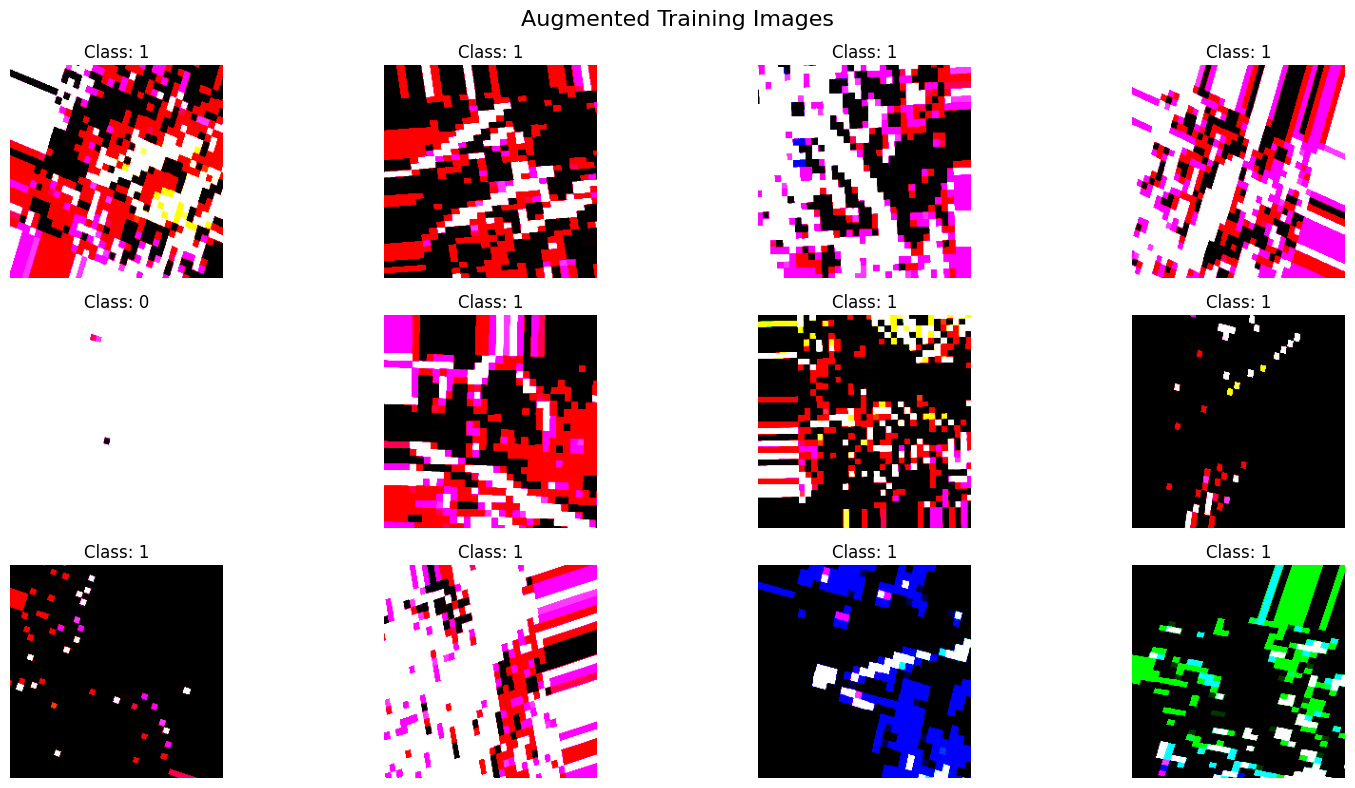

In [16]:
def plot_augmented_images(generator, title):

    x_batch, y_batch = next(generator)
    
    plt.figure(figsize=(16, 8))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"Class: {int(y_batch[i])}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_augmented_images(train_generator, 'Augmented Training Images')

## Model Implementation

In [17]:
def build_model(freeze=True, n_trainable=10):

    input_shape = (IMG_SIZE, IMG_SIZE, 3)

    input_layer = Input(shape=input_shape)
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    # Freeze base model layers
    if freeze:
        for layer in base_model.layers:
            layer.trainable = False
    else:    
        for layer in base_model.layers[-n_trainable:]:
            layer.trainable = True
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')],
    )
    
    return model

In [18]:
model = build_model(freeze=False, n_trainable=10)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 24,584,193 (93.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 6. Model Training

deal with class imbalance

In [19]:
train_labels = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 2.005156115726153, 1: 0.6660957274716909}


In [20]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_auc',
        mode='max',
        verbose=1
    )
]

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

Steps per epoch: 110
Validation steps: 28
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745291898.661224      60 service.cc:148] XLA service 0x7a1b28003660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745291898.663013      60 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745291898.663036      60 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745291903.378150      60 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745291944.040024      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9454 - auc: 0.9829 - loss: 0.1268
Epoch 1: val_auc improved from -inf to 0.99462, saving model to best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.9457 - auc: 0.9830 - loss: 0.1262 - val_accuracy: 0.9900 - val_auc: 0.9946 - val_loss: 0.0542 - learning_rate: 1.0000e-04
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9920 - auc: 0.9990 - loss: 0.0266
Epoch 2: val_auc did not improve from 0.99462
110/110 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9920 - auc: 0.9990 - loss: 0.0266 - val_accuracy: 0.9900 - val_auc: 0.9946 - val_loss: 0.0610 - learning_rate: 1.0000e-04
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9924 - auc: 0.9998 - loss: 0.0194
Epoch 3: val_auc improved from 0.99462 to 0.99593, saving model to best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9924 - auc: 0.9998 - loss: 0.0194 - val_accuracy: 0.9937 - val_auc: 0.9959 - val_loss: 0.03

In [21]:
best_model = tf.keras.models.load_model('best_model.keras')

## 7. Model Evaluation

Visualize training results:

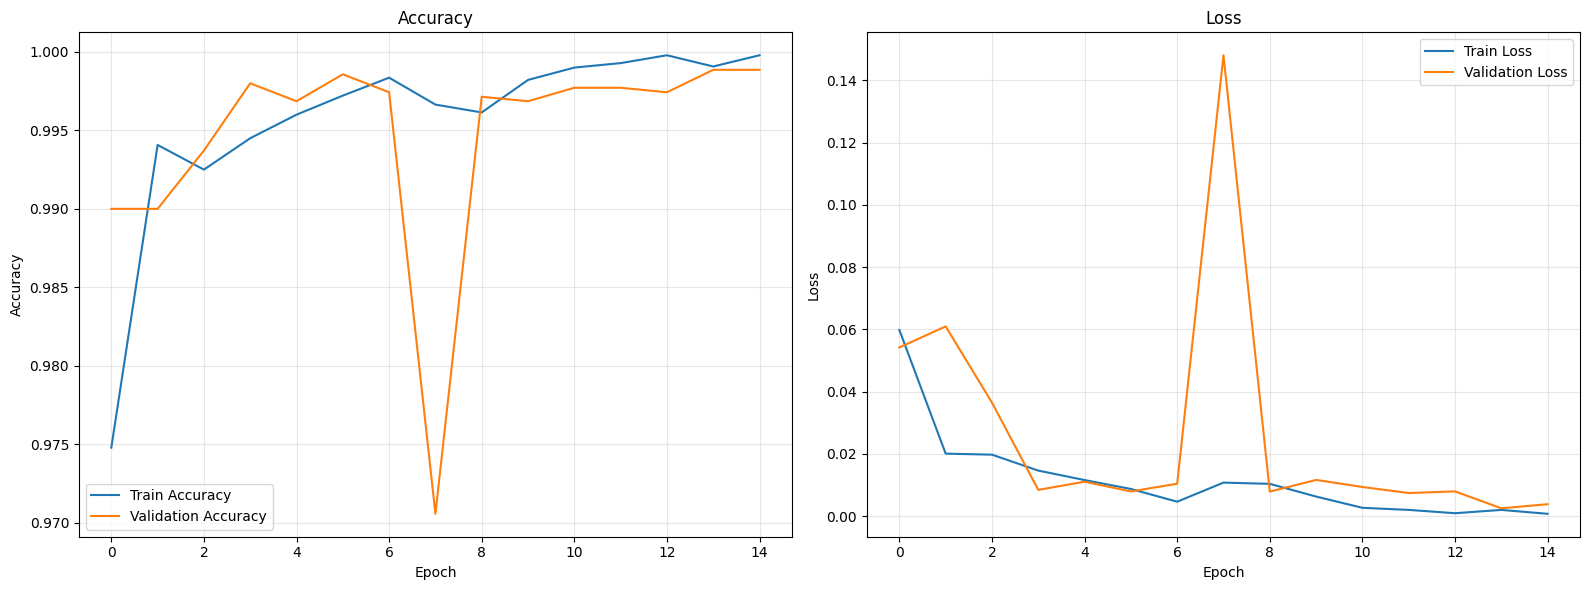

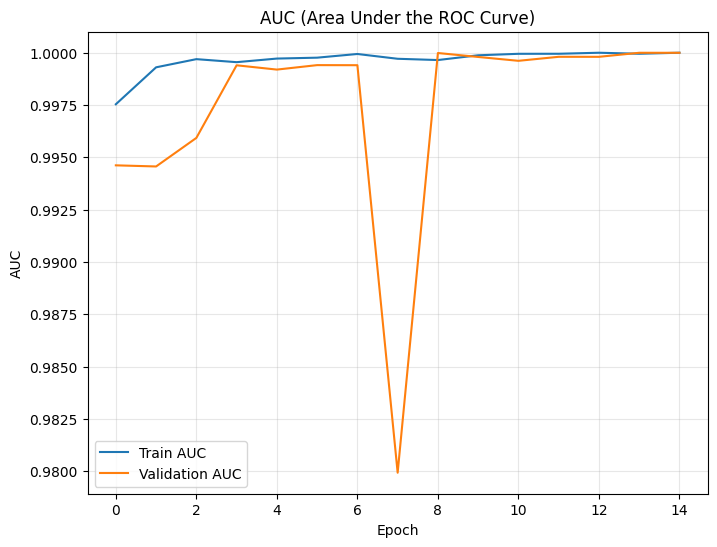

In [22]:
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(16, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot AUC
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('AUC (Area Under the ROC Curve)')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_training_history(history)

evaluate on validation set:

28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 422ms/step


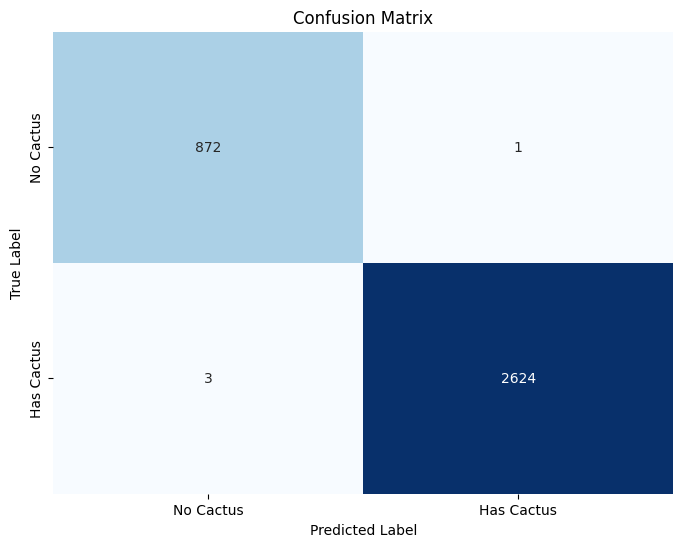

Classification Report:
              precision    recall  f1-score   support

   No Cactus       1.00      1.00      1.00       873
  Has Cactus       1.00      1.00      1.00      2627

    accuracy                           1.00      3500
   macro avg       1.00      1.00      1.00      3500
weighted avg       1.00      1.00      1.00      3500



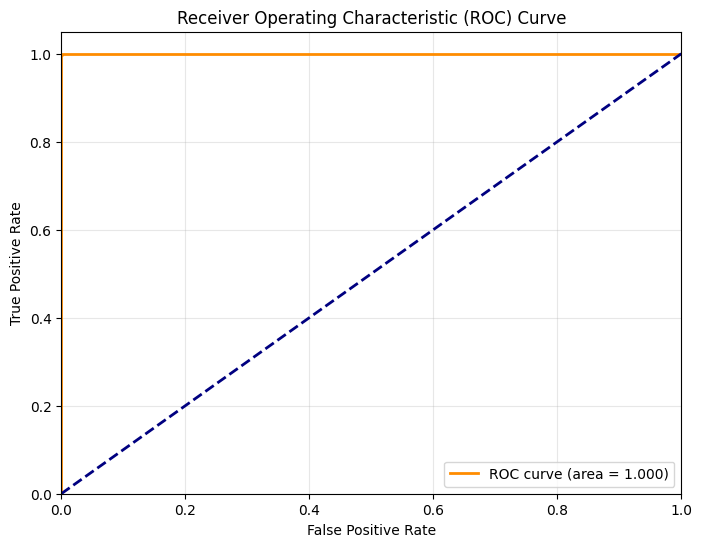

In [23]:
# Get predictions on validation set
val_generator.reset()
Y_pred = model.predict(val_generator, steps=len(val_generator))
Y_pred_classes = (Y_pred > 0.5).astype(int)
Y_true = val_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Cactus', 'Has Cactus'],
            yticklabels=['No Cactus', 'Has Cactus'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=['No Cactus', 'Has Cactus']))

# Plot ROC curve
fpr, tpr, _ = roc_curve(Y_true, Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Y_pred shape: (3500, 1)
Y_true shape: (3500,)
Y_pred range: 3.114739e-25 1.0


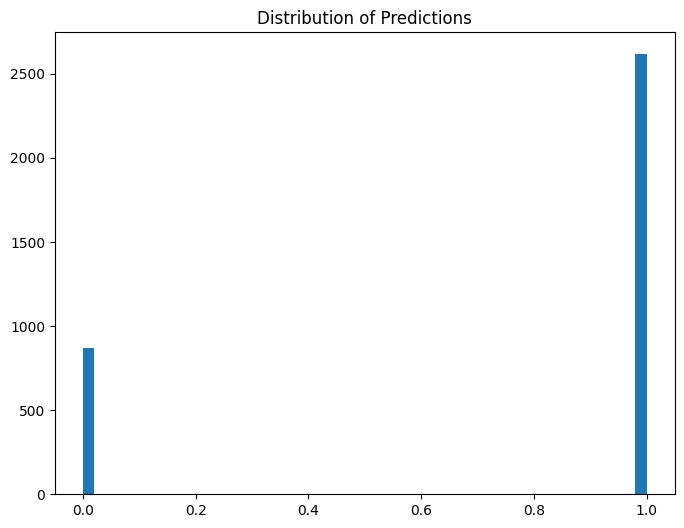

Class distribution in validation set:
[ 873 2627]
ROC AUC: 1.0000


In [24]:
# Convert Y_true to numpy array first
Y_true = np.array(Y_true)
print("Y_pred shape:", Y_pred.shape)
print("Y_true shape:", Y_true.shape)
print("Y_pred range:", np.min(Y_pred), np.max(Y_pred))

# Check distribution of predictions
plt.figure(figsize=(8, 6))
plt.hist(Y_pred, bins=50)
plt.title('Distribution of Predictions')
plt.show()

# Check class balance in true labels
print("Class distribution in validation set:")
print(np.bincount(Y_true))

# Make sure ROC calculation is correct
fpr, tpr, _ = roc_curve(Y_true, Y_pred)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")

## 8. Generate Predictions

In [25]:
# Predict on test data
test_generator.reset()
test_predictions = model.predict(test_generator, steps=len(test_generator))

# Create submission dataframe
submission['has_cactus'] = test_predictions
submission.head()

# Save submission file
submission.to_csv('submission.csv', index=False)
print("Submission saved successfully!")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step
Submission saved successfully!


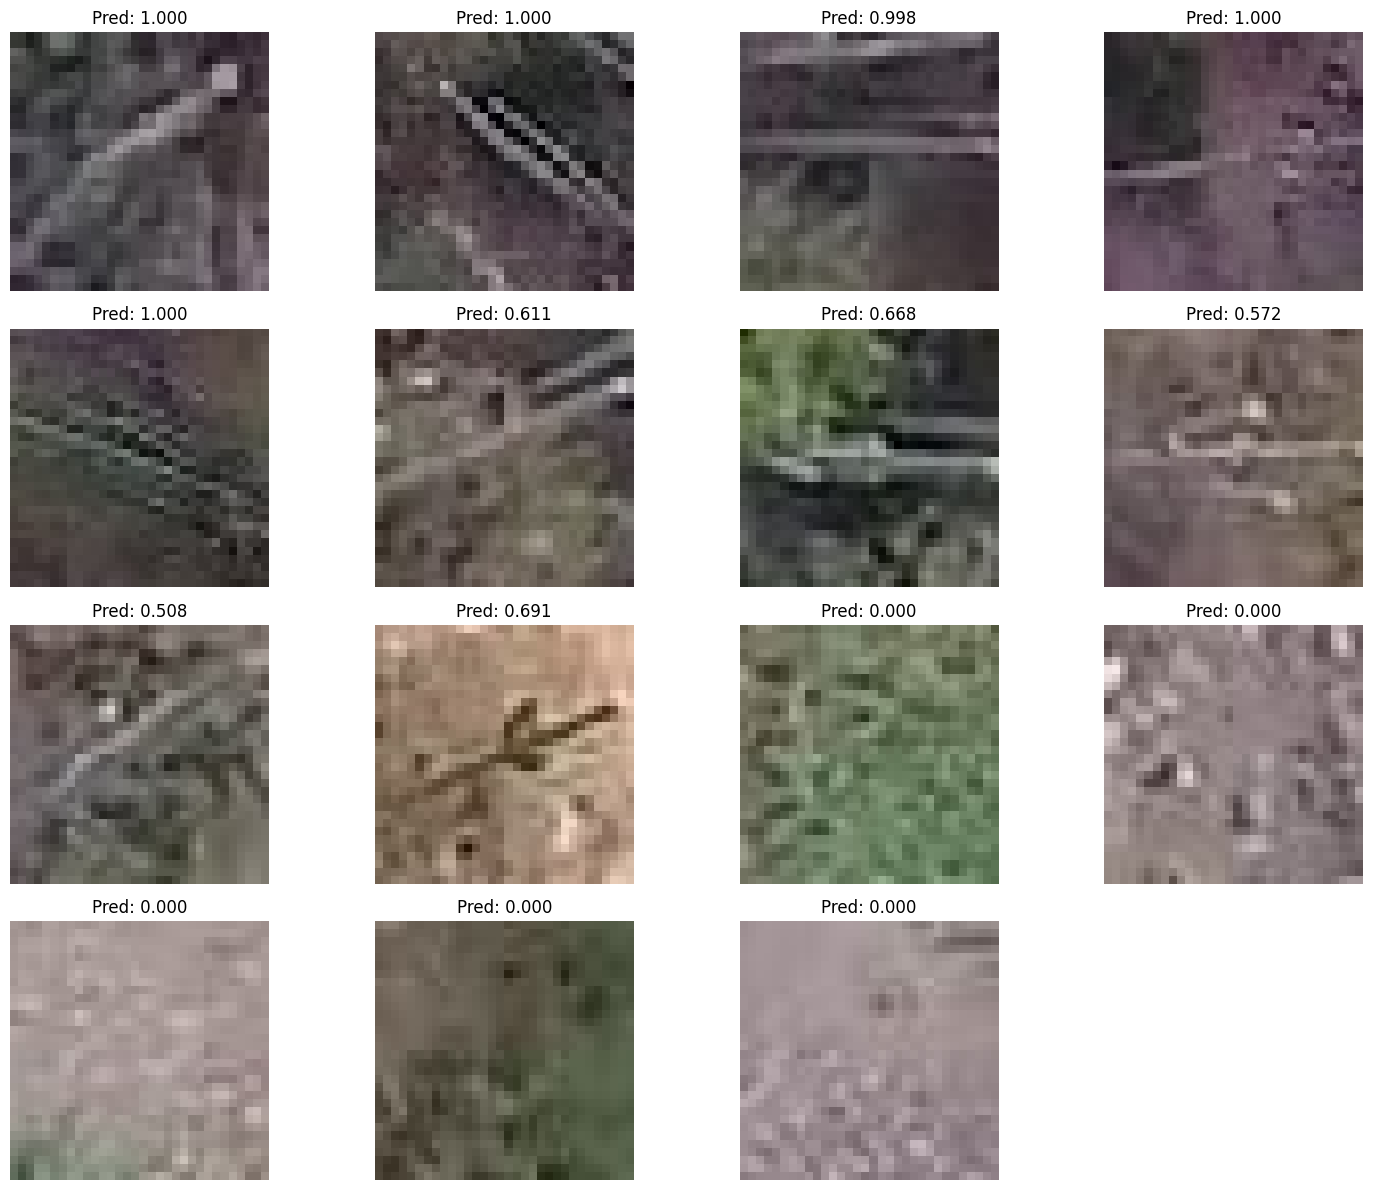

In [26]:
def display_test_predictions(submission_df, n_images=12, threshold=0.5):
    n_rows = int(np.floor(np.sqrt(n_images)))
    n_cols = int(np.ceil(n_images/n_rows))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
    axes = axes.flatten()
    
    # Get some images with a mix of predictions
    high_conf_cactus = submission_df[submission_df['has_cactus'] > 0.9]['id'].iloc[:n_images//3]
    low_conf_cactus = submission_df[(submission_df['has_cactus'] > threshold) & 
                                    (submission_df['has_cactus'] < 0.7)]['id'].iloc[:n_images//3]
    high_conf_no_cactus = submission_df[submission_df['has_cactus'] < 0.1]['id'].iloc[:n_images//3]
    
    images = pd.concat([high_conf_cactus, low_conf_cactus, high_conf_no_cactus])
    
    for idx, img_name in enumerate(images):
        if idx >= n_images:
            break
            
        img_path = 'test/' + img_name
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        pred = submission_df.loc[submission_df['id'] == img_name, 'has_cactus'].values[0]
        
        axes[idx].imshow(image)
        axes[idx].set_title(f"Pred: {pred:.3f}")
        axes[idx].axis('off')
        
        # Red border for predicted cactus, blue for no cactus
        border_color = 'red' if pred > threshold else 'blue'
        for spine in axes[idx].spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(7)
    
    for i in range(len(images), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

display_test_predictions(submission, n_images=16)